# Завдання
Використовуючи бібліотеку PyTorch, створіть генеративно-змагальну мережу (GAN) для генерації зображень цифр MNIST:

1. Завантажте набір даних MNIST з використанням torchvision.datasets.
2. Створіть генератор, який приймає на вхід випадковий вектор з шумом та генерує зображення цифр MNIST.
3. Створіть дискримінатор, який приймає на вхід зображення цифр MNIST та визначає, чи є це реальне зображення чи згенероване генератором.
4. Обидві моделі повинні мати декілька шарів зі зменшенням розмірності зображення, використовуючи згортувальні та пулінгові шари.
5. Навчіть моделі генерувати нові зображення цифр MNIST, використовуючи взаємодію генератора та дискримінатора з використанням функції втрат GAN (adversarial loss).
6. Після навчання, виведіть кілька згенерованих зображень та порівняйте їх з оригінальними зображеннями з набору даних MNIST.

## Рішення
### Імпорт бібліотек

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Імпорт даних

In [2]:
# Для конвертації зображень у Тензор на нормалізації в межах від 0 до 1
transform = transforms.Compose([
transforms.ToTensor()
]
        )

# Імпорт набору даних MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform) # Перетворення зображень в тензори та нормалізація train
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                download=True, transform=transform) # Перетворення зображень в тензори та нормалізація test
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                    shuffle=True, num_workers=2, drop_last=True) # Завантаження даних для тренування
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                    shuffle=False, num_workers=2, drop_last=True) # Завантаження даних для тестування

In [3]:
# Ініціалізація  гіперпараметрів

device = 'cuda'     # використовуємо GPU
zd = 64             # розмір шуму
num_classes = 10    # кількість класів
lr = 0.0002         # швидкість навчання
num_epochs = 100    # кількість епох
batch_size = 128    # розмір батча

### GAN модель

In [4]:
# Ініціалізація генератора
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self). __init__()
        self.convT_layers = nn.Sequential(
              nn.ConvTranspose2d(74, 64, kernel_size=3, stride=2, padding=0),
              nn.BatchNorm2d(64),
              nn.Tanh(),
              nn.ConvTranspose2d(64, 128, kernel_size=4, stride=1, padding=0),
              nn.BatchNorm2d(128),
              nn.Tanh(),
              nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
              nn.BatchNorm2d(64),
              nn.Tanh(),
              nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=0),
              nn.BatchNorm2d(1),
              nn.ReLU()


        )
    def forward(self, z):
        x = self.convT_layers(z)
        return x

# Ініціалізація ваг генератора
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()


# Ініціалізація дискримінатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        out = x.view(x.size(0), -1)
        return out

 # Ініціалізація ваг дискримінатора
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()

### Навчання моделі

In [5]:
# Створення словника для зберігання відповідних зображень і значень
log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'Fake_Images': [],
                'Real_Images': []}


# Ініціалізація моделей
D = Discriminator().to(device)
D.init_weights()

G = Generator().to(device)
G.init_weights()

# Оптимізатори
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


# Переведення моделей в режим тренування
D.train()
G.train()

# Критерій loss
criterion = nn.BCEWithLogitsLoss()

# Цикл тренування
for epoch in range(num_epochs):
    for batch_idx, (real_images, labels) in enumerate(train_loader):

        # Справжні мітки - одиниці, а фальшиві мітки – нулі, щоб дискримінатор міг
        # навчитися розпізнавати справжні та підроблені зображення
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        real_images = real_images.to(device)
        labels = labels.to(device)
        # Визначення міток для  функції втрат генератора.
        flipped_fake_labels = real_labels

        # Оптимізація тільки дискримінатора
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, zd).to(device)

        class_labels = torch.zeros(batch_size, num_classes).to(device)
        class_label_onehot = class_labels.scatter_(1, labels.view(batch_size, 1), 1)
        G_concat = torch.cat((z, class_label_onehot), dim=1)
        G_concat = G_concat.unsqueeze(2)
        G_concat = G_concat.unsqueeze(3)

        # Генерація фальшивих зображень
        fake_images = G(G_concat)
        fake_images = fake_images.to(device)


        # Створення масиву для зберігання міток класів
        Cm = torch.zeros((batch_size, 10, 28, 28)).to(device)
        for i in range(batch_size):
            n = labels[i].item()
            Cm[i, n, :, :] = 1

        D_real_concat = torch.cat((real_images, Cm), dim = 1)
        D_fake_concat =  torch.cat((fake_images.detach(), Cm), dim = 1)
        real_predictions = D(D_real_concat)
        fake_predictions = D(D_fake_concat)

        # Обчислення втрат дискримінатора
        loss_D_real = criterion(real_predictions, real_labels)
        loss_D_fake = criterion(fake_predictions, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        loss_D.backward()
        optimizer_D.step()
        
        # Оптимізація тільки генератора
        optimizer_G.zero_grad()

        # Обчислення прогнозів Дискримінатора на фальшивих зображеннях
        fake_predictions = D(torch.cat((fake_images, Cm), dim=1))

        # Обчислення втрат генератора
        loss_G = criterion(fake_predictions, flipped_fake_labels)

        loss_G.backward()
        optimizer_G.step()

    log_dict['train_generator_loss_per_batch'].append(loss_G.item())
    log_dict['train_discriminator_loss_per_batch'].append(loss_D.item())
    if epoch == 0 or epoch == 99:
        log_dict['Fake_Images'].append(
            torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
        log_dict['Real_Images'].append(
            torchvision.utils.make_grid(real_images, padding=2, normalize=True))
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

torch.save({
'model_state_dict': G.state_dict(),
'train_loader': train_loader,
'test_loader': test_loader,
'log_dict' : log_dict,
}, 'Generator_Model.pt')
print('Model Saved')

Epoch [1/100] Loss D: 1.4182, Loss G: 0.4981
Epoch [2/100] Loss D: 1.4408, Loss G: 0.5030
Epoch [3/100] Loss D: 1.4245, Loss G: 0.5129
Epoch [4/100] Loss D: 1.4236, Loss G: 0.5173
Epoch [5/100] Loss D: 1.4290, Loss G: 0.5272
Epoch [6/100] Loss D: 1.4167, Loss G: 0.5371
Epoch [7/100] Loss D: 1.4126, Loss G: 0.5415
Epoch [8/100] Loss D: 1.4147, Loss G: 0.5485
Epoch [9/100] Loss D: 1.4106, Loss G: 0.5574
Epoch [10/100] Loss D: 1.4086, Loss G: 0.5629
Epoch [11/100] Loss D: 1.4153, Loss G: 0.5653
Epoch [12/100] Loss D: 1.4135, Loss G: 0.5656
Epoch [13/100] Loss D: 1.4021, Loss G: 0.5800
Epoch [14/100] Loss D: 1.4065, Loss G: 0.5850
Epoch [15/100] Loss D: 1.4042, Loss G: 0.5898
Epoch [16/100] Loss D: 1.3975, Loss G: 0.5938
Epoch [17/100] Loss D: 1.4127, Loss G: 0.5958
Epoch [18/100] Loss D: 1.4046, Loss G: 0.6026
Epoch [19/100] Loss D: 1.4014, Loss G: 0.5997
Epoch [20/100] Loss D: 1.4039, Loss G: 0.6018
Epoch [21/100] Loss D: 1.4013, Loss G: 0.6128
Epoch [22/100] Loss D: 1.4027, Loss G: 0.57

### Візуалізація результатів

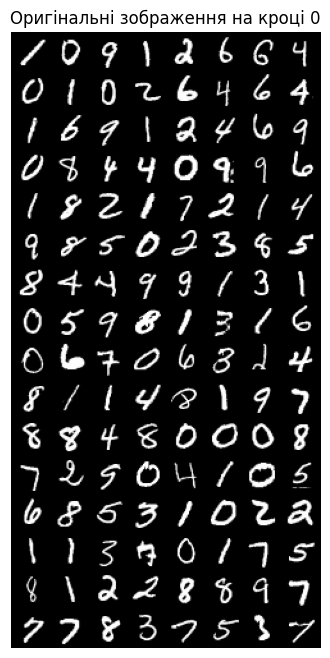

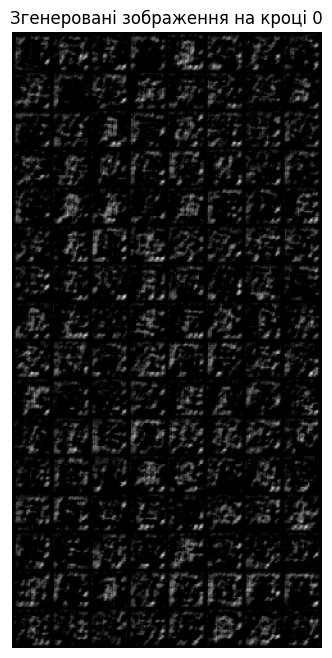

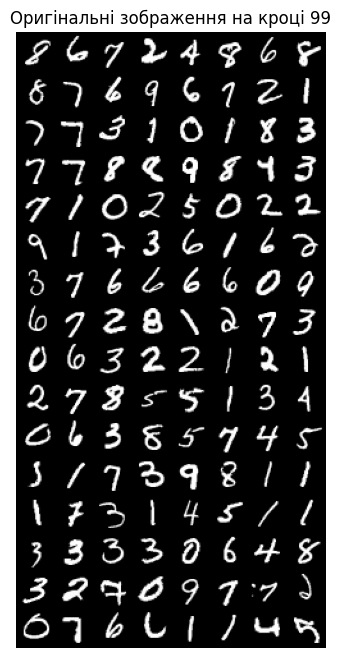

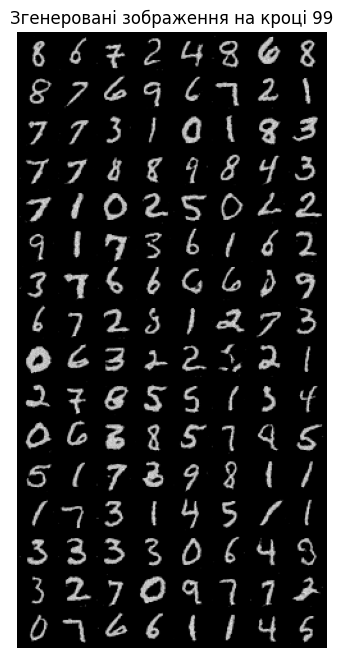

In [9]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Оригінальні зображення на кроці {0}')
img = log_dict['Real_Images'][0].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Згенеровані зображення на кроці {0}')
img = log_dict['Fake_Images'][0].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Оригінальні зображення на кроці {99}')
img = log_dict['Real_Images'][1].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Згенеровані зображення на кроці {99}')
img = log_dict['Fake_Images'][1].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

### Візуалізація втрат моделей

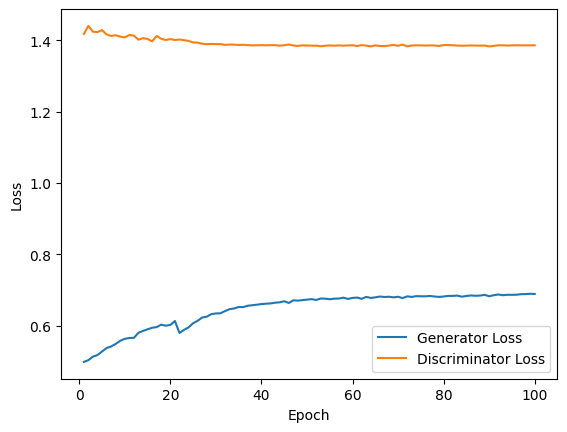

In [10]:
# Отримання втрати генератора та дискримінатора з log_dict
gen_losses = log_dict['train_generator_loss_per_batch']
disc_losses = log_dict['train_discriminator_loss_per_batch']

# Створення порядку епох
epochs = list(range(1, len(gen_losses) + 1))

# Візуалізація втрат
plt.plot(epochs, gen_losses, label='Generator Loss')
plt.plot(epochs, disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()